# Анализ бизнес-показателей

## Описание проекта

Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Ваша задача — разобраться в причинах и помочь компании выйти в плюс.
Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:<br>
•	лог сервера с данными об их посещениях,<br>
•	выгрузка их покупок за этот период,<br>
•	рекламные расходы.<br>
Вам предстоит изучить:<br>
•	откуда приходят пользователи и какими устройствами они пользуются,<br>
•	сколько стоит привлечение пользователей из различных рекламных каналов,<br>
•	сколько денег приносит каждый клиент,<br>
•	когда расходы на привлечение клиента окупаются,<br>
•	какие факторы мешают привлечению клиентов.

## Подготовка данных к анализу

### Загрузка данных

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    sessions = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')

except FileNotFoundError:
    sessions = pd.read_csv('visits_info_short.csv')
    orders = pd.read_csv('orders_info_short.csv')
    costs = pd.read_csv('costs_info_short.csv')

In [3]:
data = [sessions, orders, costs]
for data in data:
    data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null object
Revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Некорректные имена столбцов и типы данных в столбцах дат.
Загружу по новой таблицы с переименованием столбцов и преобразованием типов дат:

In [4]:
name_visit = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
name_order = ['user_id', 'event_dt', 'revenue']
name_costs = ['dt', 'channel', 'costs']


try:
    sessions = pd.read_csv('/datasets/visits_info_short.csv', names=name_visit, parse_dates=['session_start', 'session_end'], header=0)
    orders = pd.read_csv('/datasets/orders_info_short.csv', names=name_order, parse_dates=['event_dt'], header=0)
    costs = pd.read_csv('/datasets/costs_info_short.csv', names=name_costs, header=0)

except FileNotFoundError:
    sessions = pd.read_csv('visits_info_short.csv', names=name_visit, parse_dates=['session_start', 'session_end'], header=0)
    orders = pd.read_csv('orders_info_short.csv', names=name_order,parse_dates=['event_dt'], header=0)
    costs = pd.read_csv('costs_info_short.csv', names=name_costs, header=0)

### Подготовка таблиц

#### Таблица sessions

In [5]:
sessions.sample(5)

,user_id,region,device,channel,session_start,session_end
183510,964553364221,United States,iPhone,RocketSuperAds,2019-10-11 16:44:13,2019-10-11 17:28:30
40766,494446936158,United States,iPhone,organic,2019-06-12 21:06:38,2019-06-12 21:46:51
50538,360506979574,United States,Android,organic,2019-06-23 09:25:16,2019-06-23 10:11:58
25680,946567493078,United States,Mac,organic,2019-05-27 01:49:04,2019-05-27 02:15:15
2282,994226028981,United States,Mac,organic,2019-05-04 02:03:19,2019-05-04 02:29:41


In [6]:
sessions.duplicated().sum()

0

In [7]:
sessions['device'].value_counts()

iPhone     112603
Android     72590
PC          62686
Mac         62022
Name: device, dtype: int64

In [8]:
sessions['region'].value_counts()

United States    207327
UK                36419
France            35396
Germany           30759
Name: region, dtype: int64

In [9]:
sessions['channel'].value_counts()

organic               107760
TipTop                 54794
FaceBoom               49022
WahooNetBanner         20465
LeapBob                17013
OppleCreativeMedia     16794
RocketSuperAds         12724
YRabbit                 9053
MediaTornado            8878
AdNonSense              6891
lambdaMediaAds          6507
Name: channel, dtype: int64

In [10]:
sessions.isna().sum()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

Добавлю столбец с длительностью сессии в секундах:

In [11]:
sessions['session_duration'] = (sessions['session_start'] - sessions['session_end']).dt.seconds

Удалю несостоявшиеся сессии и ошибочные данные, если вдруг такие имеются - т.е. строки с длительностью сессий равной или меньше 0:

In [12]:
sessions = sessions[sessions['session_duration'] > 0]

In [13]:
sessions['session_duration'].describe()

count    309738.000000
mean      84598.961832
std        1803.064839
min       64143.000000
25%       83903.000000
50%       85156.000000
75%       85882.000000
max       86399.000000
Name: session_duration, dtype: float64

Отсеялось 10133 строк. Теперь все сессии в таблице с нормальной длительностью.

In [14]:
sessions['session_start'].describe()

count                  309738
unique                 306655
top       2019-09-02 05:57:01
freq                        3
first     2019-05-01 00:00:41
last      2019-10-31 23:59:23
Name: session_start, dtype: object

In [15]:
sessions.sample(5)

,user_id,region,device,channel,session_start,session_end,session_duration
46525,156296986385,United States,iPhone,organic,2019-06-19 07:21:04,2019-06-19 07:36:53,85451
5995,122486403337,United States,iPhone,TipTop,2019-05-08 22:19:47,2019-05-08 22:24:58,86089
31394,940661507060,United States,Mac,FaceBoom,2019-06-01 06:25:50,2019-06-01 06:37:22,85708
235572,622515458313,UK,PC,OppleCreativeMedia,2019-06-28 05:33:03,2019-06-28 05:56:06,85017
230171,150621299024,UK,PC,organic,2019-06-17 10:42:07,2019-06-17 11:05:13,85014


#### Таблица orders

In [16]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
user_id     40212 non-null int64
event_dt    40212 non-null datetime64[ns]
revenue     40212 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [17]:
orders.duplicated().sum()

0

In [18]:
orders['event_dt'].describe()

count                   40212
unique                  40163
top       2019-10-31 06:23:16
freq                        2
first     2019-05-01 00:28:11
last      2019-10-31 23:56:56
Name: event_dt, dtype: object

In [19]:
orders.isna().sum()

user_id     0
event_dt    0
revenue     0
dtype: int64

#### Таблица costs

In [20]:
costs.head(5)

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [21]:
costs.duplicated().sum()

0

Преобразую тип данных даты:

In [22]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [23]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [24]:
costs['channel'].value_counts()

LeapBob               180
TipTop                180
YRabbit               180
AdNonSense            180
FaceBoom              180
OppleCreativeMedia    180
lambdaMediaAds        180
WahooNetBanner        180
MediaTornado          180
RocketSuperAds        180
Name: channel, dtype: int64

In [25]:
costs['costs'].describe()

count    1800.000000
mean       58.609611
std       107.740223
min         0.800000
25%         6.495000
50%        12.285000
75%        33.600000
max       630.000000
Name: costs, dtype: float64

## Функции

### get_profiles - функция пользовательских профилей.

In [26]:
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            # проверяем, встречается ли каждый пользователь
            # среди тех, кто совершил событие event
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### get_retention - функция для расчёта удержания

In [27]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### get_conversion - функция для расчёта конверсии

In [28]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### get_ltv - функция для расчёта LTV и ROI

In [29]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC,
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### filter_data - функция для сглаживания фрейма

In [30]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df

### plot_conversion - функция для визуализации конверсии

In [31]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### plot_retention - функция для визуализации удержания

In [32]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )

    plt.tight_layout()
    plt.show()

### plot_ltv_roi - функция для визуализации LTV и ROI

In [33]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Переменные и промежуточные таблицы

События events отсутствуют:

In [34]:
events = None

Момент анализа:

In [35]:
observation_date = datetime(2019, 11, 1).date()

Горизонт анализа:

In [36]:
horizon_days = 14

С помощью функции get_profiles создам таблицу пользовательских профилей.

In [37]:
users = get_profiles(sessions, orders, events, costs)

Таблица пользовательских профилей без органических пользователей:

In [38]:
user_payer = users[~(users['channel'] == 'organic')]

Минимальная и максимальная дата привлечения пользователей:

In [39]:
min_analysis_date = users['dt'].min()
max_analysis_date = observation_date - timedelta(days=horizon_days - 1)
print('Минимальная дата привлечения пользователей:', min_analysis_date)
print()
print('Максимальная дата привлечения пользователей:', max_analysis_date)

Минимальная дата привлечения пользователей: 2019-05-01

Максимальная дата привлечения пользователей: 2019-10-19


## Исследовательский анализ данных

In [40]:
users.sample(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
47361,314076023826,2019-09-06 01:39:18,OppleCreativeMedia,Android,France,2019-09-06,2019-09-01,False,0.250000
39176,260138713040,2019-09-15 09:25:11,FaceBoom,iPhone,United States,2019-09-15,2019-09-01,False,1.112500
31826,211426641814,2019-06-11 19:35:49,TipTop,iPhone,United States,2019-06-11,2019-06-01,False,1.950667
116182,774423792148,2019-09-04 21:21:33,TipTop,iPhone,United States,2019-09-04,2019-09-01,False,3.500000
125167,834743937289,2019-08-18 02:35:40,AdNonSense,PC,France,2019-08-18,2019-08-01,False,0.840000


Выясню, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей:

In [41]:
user_region = (users.groupby('region').agg({'user_id': 'nunique', 'payer': 'mean'})).sort_values(by = 'payer', ascending = False)
user_region['doly, %'] = (user_region['user_id'] / user_region['user_id'].sum() * 100).round(1)
print(user_region)

               user_id     payer  doly, %
region                                   
United States    99976  0.069037     66.7
Germany          14978  0.041127     10.0
UK               17573  0.039834     11.7
France           17444  0.038007     11.6


Узнаю, какими устройствами пользуются клиенты, и какие устройства предпочитают платящие пользователи.

In [42]:
user_device = (users.groupby('device').agg({'user_id': 'nunique', 'payer': 'mean'})).sort_values(by = 'payer', ascending = False)
user_device['doly, %'] = (user_device['user_id'] / user_device['user_id'].sum() * 100).round(1)
print(user_device)

         user_id     payer  doly, %
device                             
Mac        30037  0.063655     20.0
iPhone     54460  0.062101     36.3
Android    35025  0.058530     23.4
PC         30449  0.050478     20.3


Количество посетителей, привлечённых каждым рекламным источником:

In [43]:
user_channel = (users.groupby('channel').agg({'user_id': 'nunique', 'payer': 'mean'})).sort_values(by = 'payer', ascending = False)
user_channel['doly, %'] = (user_channel['user_id'] / user_channel['user_id'].sum() * 100).round(1)
print(user_channel)

                    user_id     payer  doly, %
channel                                       
FaceBoom              29135  0.122087     19.4
AdNonSense             3880  0.113402      2.6
lambdaMediaAds         2149  0.104700      1.4
TipTop                19556  0.096032     13.0
RocketSuperAds         4447  0.079154      3.0
WahooNetBanner         8549  0.052989      5.7
YRabbit                4312  0.038265      2.9
MediaTornado           4363  0.035755      2.9
LeapBob                8552  0.030636      5.7
OppleCreativeMedia     8602  0.027087      5.7
organic               56426  0.020558     37.6


### Промежуточный вывод:

Самая большая когорта пользователей - 66.7% приходится на United States и там же самая высокая доля payer - 0.07.<br>
Используемые устройства в целом распределены равномерно, но пользователей iPhone более других - 36.3%, и платят больше с Mac.<br>
За исключением organic, более всего привлекают посетителей FaceBoom и TipTop. И показатель payer лучше всего у FaceBoom.


## Маркетинг

Общая сумма расходов на маркетинг:

In [44]:
costs_total = users['acquisition_cost'].sum()
print('Общая сумма расходов на маркетинг:', costs_total.round(0))

Общая сумма расходов на маркетинг: 105497.0


Расходы на маркетинг по источникам:

In [45]:
costs_channel = user_payer.groupby('channel').agg({'acquisition_cost': 'sum'}).sort_values(by = 'acquisition_cost', ascending = False)
costs_channel['doly, %'] = (costs_channel['acquisition_cost'] / costs_channel['acquisition_cost'].sum() * 100).round(1)
print(costs_channel)

                    acquisition_cost  doly, %
channel                                      
TipTop                      54751.30     51.9
FaceBoom                    32445.60     30.8
WahooNetBanner               5151.00      4.9
AdNonSense                   3911.25      3.7
OppleCreativeMedia           2151.25      2.0
RocketSuperAds               1833.00      1.7
LeapBob                      1797.60      1.7
lambdaMediaAds               1557.60      1.5
MediaTornado                  954.48      0.9
YRabbit                       944.22      0.9


In [46]:
metric = user_payer.pivot_table(index='dt', columns='channel', values='acquisition_cost', aggfunc='sum')

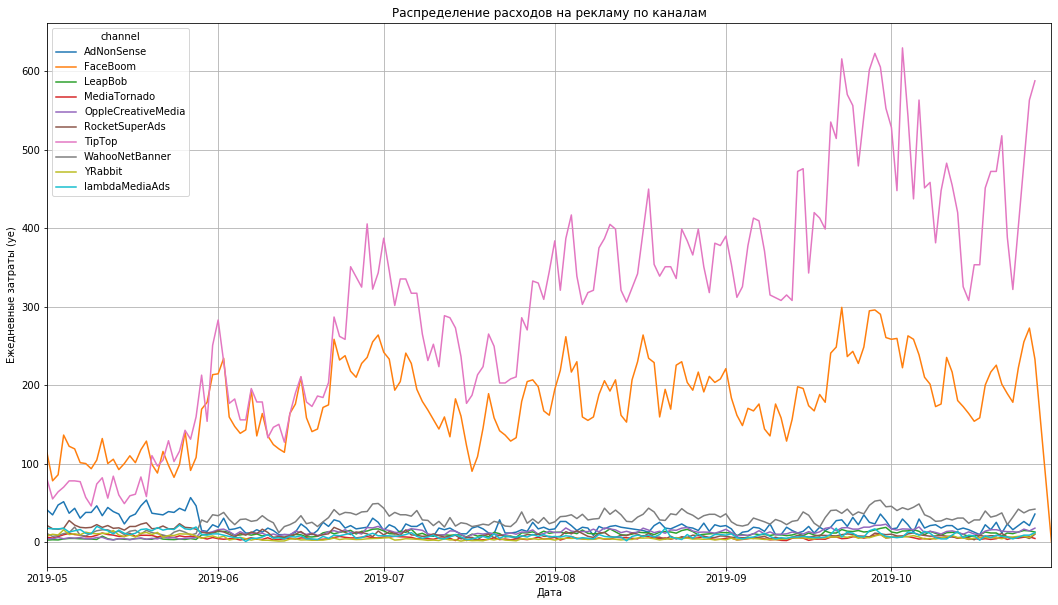

In [47]:
metric.plot(figsize=(18,10), grid=True)
plt.xlabel('Дата')
plt.ylabel('Ежедневные затраты (уе)')
plt.title('Распределение расходов на рекламу по каналам')

plt.show()

In [48]:
metric_tot = user_payer.pivot_table(index='dt', values='acquisition_cost', aggfunc='sum')

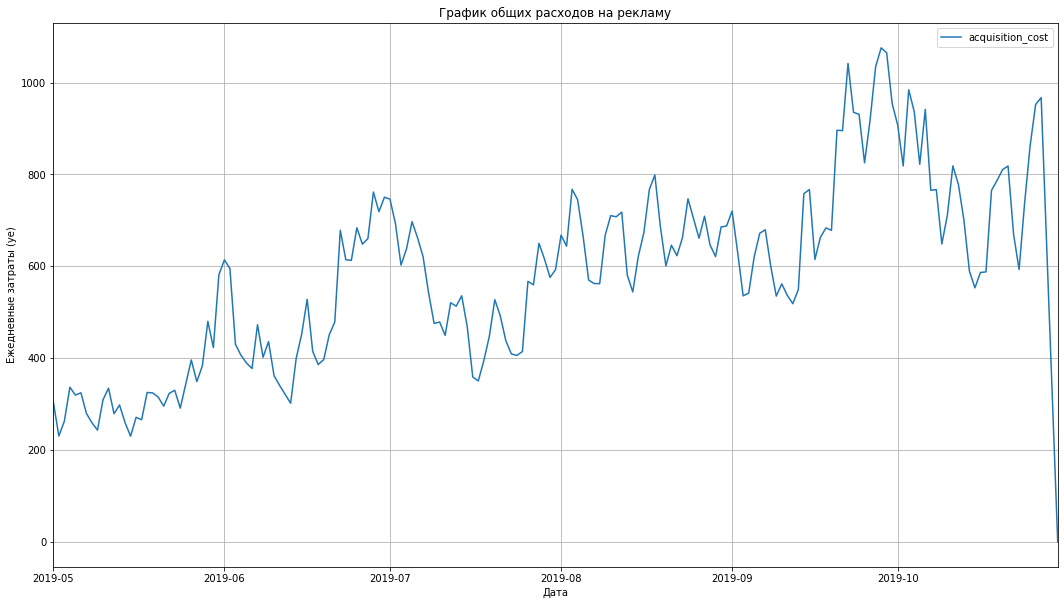

In [49]:
metric_tot.plot(figsize=(18,10), grid=True)
plt.xlabel('Дата')
plt.ylabel('Ежедневные затраты (уе)')
plt.title('График общих расходов на рекламу')

plt.show()

Средняя стоимость (CAC) привлечения одного пользователя в целом по проекту:

In [50]:
cac_user_project = (user_payer['acquisition_cost'].sum() / len(user_payer['user_id'])).round(3)
print('CAC по проекту:', cac_user_project)

CAC по проекту: 1.128


Средняя стоимость(CAC) привлечения одного пользователя из каждого источника:

In [51]:
cac_user_channel = (user_payer.groupby('channel').agg({'acquisition_cost': 'mean'})).sort_values(by = 'acquisition_cost', ascending = False)
print(cac_user_channel)

                    acquisition_cost
channel                             
TipTop                      2.799719
FaceBoom                    1.113630
AdNonSense                  1.008054
lambdaMediaAds              0.724802
WahooNetBanner              0.602527
RocketSuperAds              0.412188
OppleCreativeMedia          0.250087
YRabbit                     0.218975
MediaTornado                0.218767
LeapBob                     0.210196


In [52]:
cac_user_channel.mean()

acquisition_cost    0.755894
dtype: float64

### Промежуточный вывод

82.7% всех расходов на рекламу приходится на два источника рекламы: TipTop - 51.9% и FaceBoom - 30.8%. 
При этом у TipTop самя высокая стоимость привлечений одного пользователя. 

## Оценка окупаемости рекламы

### Общая окупаемость рекламы

In [53]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    user_payer, orders, observation_date, horizon_days)

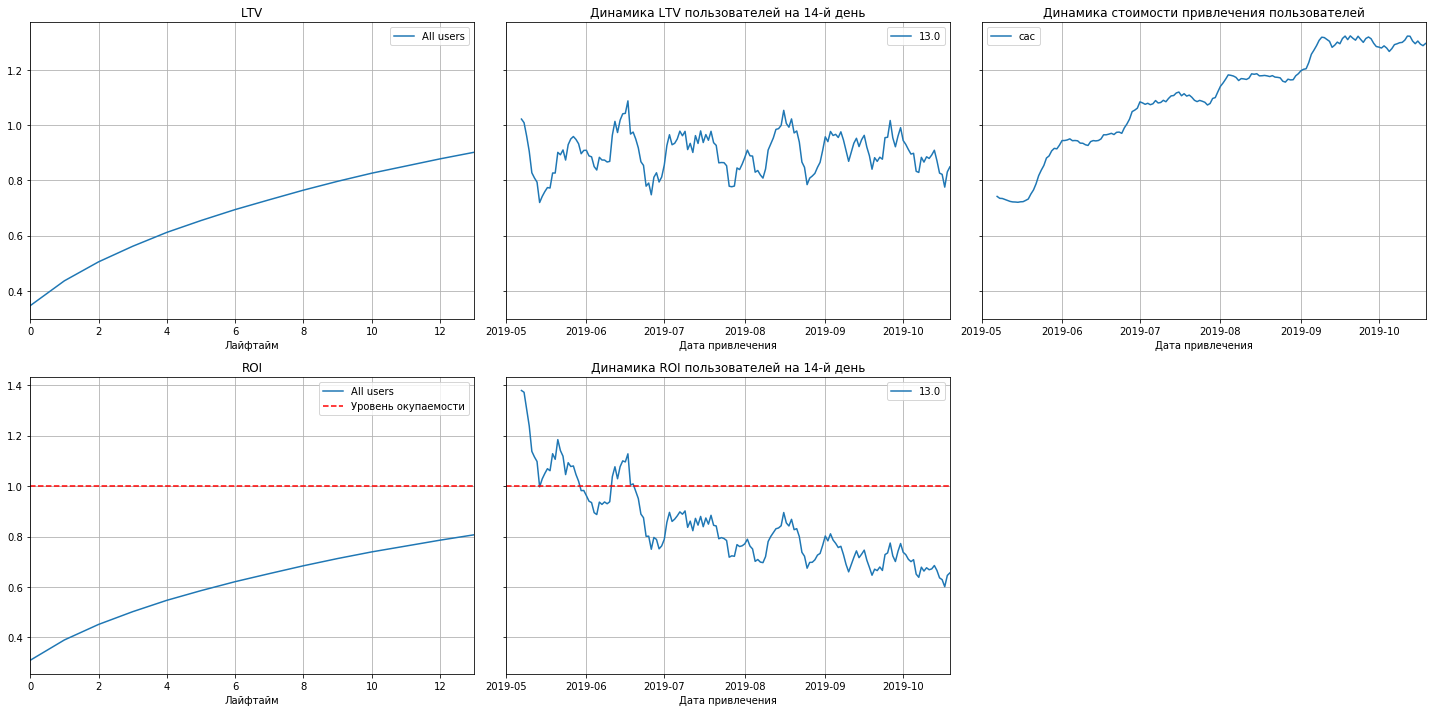

In [54]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать такие выводы:<br>
Реклама не окупается. Динамика ROI стабильно снижается. В конце второй недели — чуть выше 80%.<br>
CAC растёт. Отмечу этот факт.<br>
LTV достаточно стабилен. Значит, дело не в ухудшении качества пользователей.<br>
Чтобы разобраться в причинах, пройдём по всем доступным характеристикам пользователей — стране, источнику и устройству первого посещения.

### Окупаемость рекламы с разбивкой по рекламным каналам:

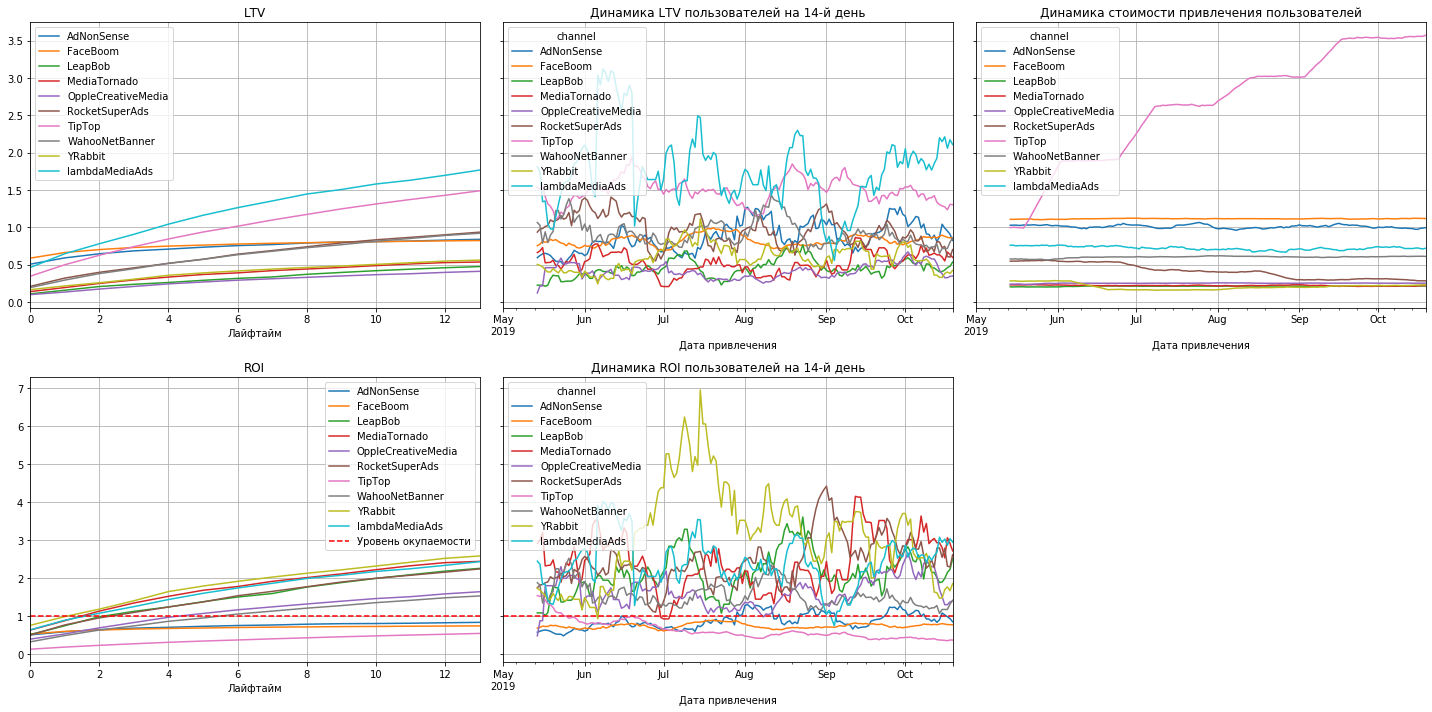

In [55]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    user_payer, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

По графикам динамика прослеживается, но из-за множества линий проблематично точно зафиксировать источники рекламы с ROI меньше 0, для этого гляну на таблицу roi_grouped:

In [56]:
roi_grouped.sort_values(by = 'cac', ascending = False)

,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,,
TipTop,18493,2.758519,0.124575,0.180359,0.226321,0.268272,0.305546,0.339298,0.367570,0.397585,0.424763,0.451627,0.475535,0.497310,0.517679,0.539532
FaceBoom,27534,1.113823,0.526040,0.593347,0.629180,0.654436,0.670873,0.682751,0.695638,0.704655,0.711523,0.719041,0.723956,0.729326,0.734047,0.737627
AdNonSense,3702,1.008023,0.501010,0.584460,0.639288,0.678069,0.701069,0.726752,0.748147,0.761519,0.782922,0.796294,0.800573,0.808597,0.820631,0.831337
lambdaMediaAds,2056,0.727237,0.632899,0.887333,1.070887,1.245178,1.432136,1.595673,1.735841,1.859323,1.986818,2.070251,2.171709,2.241794,2.331922,2.428712
WahooNetBanner,8078,0.602154,0.317853,0.484298,0.629588,0.737309,0.858780,0.946188,1.049868,1.126808,1.205193,1.271878,1.350049,1.411192,1.477881,1.526304
RocketSuperAds,4250,0.417529,0.497256,0.763336,0.948932,1.092347,1.235204,1.367935,1.531090,1.646391,1.767923,1.892809,1.991795,2.070538,2.152657,2.237019
OppleCreativeMedia,8136,0.250000,0.389100,0.526504,0.686996,0.826849,0.964769,1.065354,1.161037,1.238564,1.314661,1.388265,1.457448,1.507006,1.580649,1.637075
MediaTornado,4166,0.219088,0.627684,0.874814,1.127410,1.340729,1.516873,1.675432,1.773841,1.910531,2.008962,2.107371,2.216726,2.320602,2.402610,2.436519
YRabbit,4102,0.217087,0.752238,0.983122,1.179250,1.400049,1.641119,1.786814,1.910094,2.022179,2.123045,2.212703,2.313569,2.414457,2.516446,2.578086


Стабильные качество пользователей, но стоимость привлечения пользователей CAC стабильно для всех, кроме TipTop.<br>
ROI стабильно ниже нуля у TipTop, FaceBoom, AdNonSense

### Окупаемость рекламы с разбивкой по странам:

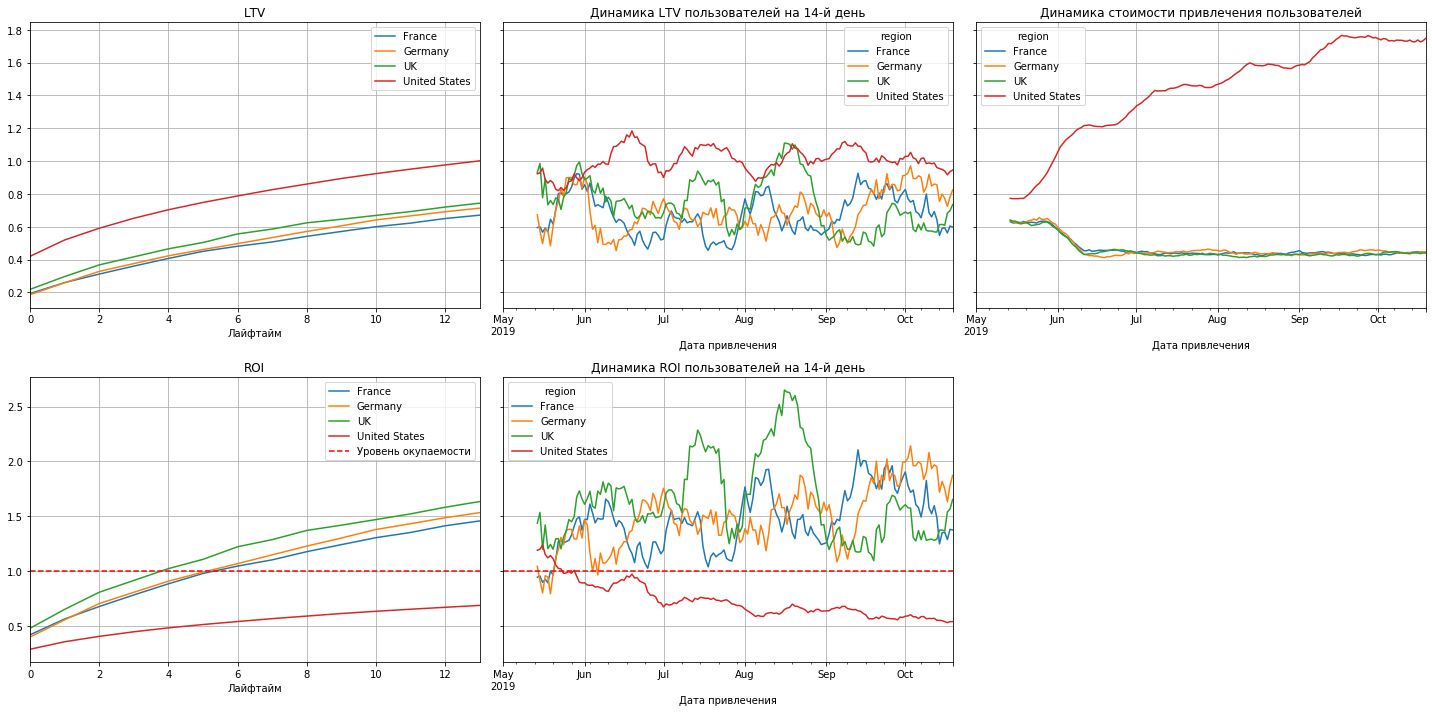

In [57]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    user_payer, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Судя по графикам самая многочисленная когорта из США тянет вниз все показатели окупаемости.

### Окупаемость рекламы с разбивкой по устройствам:

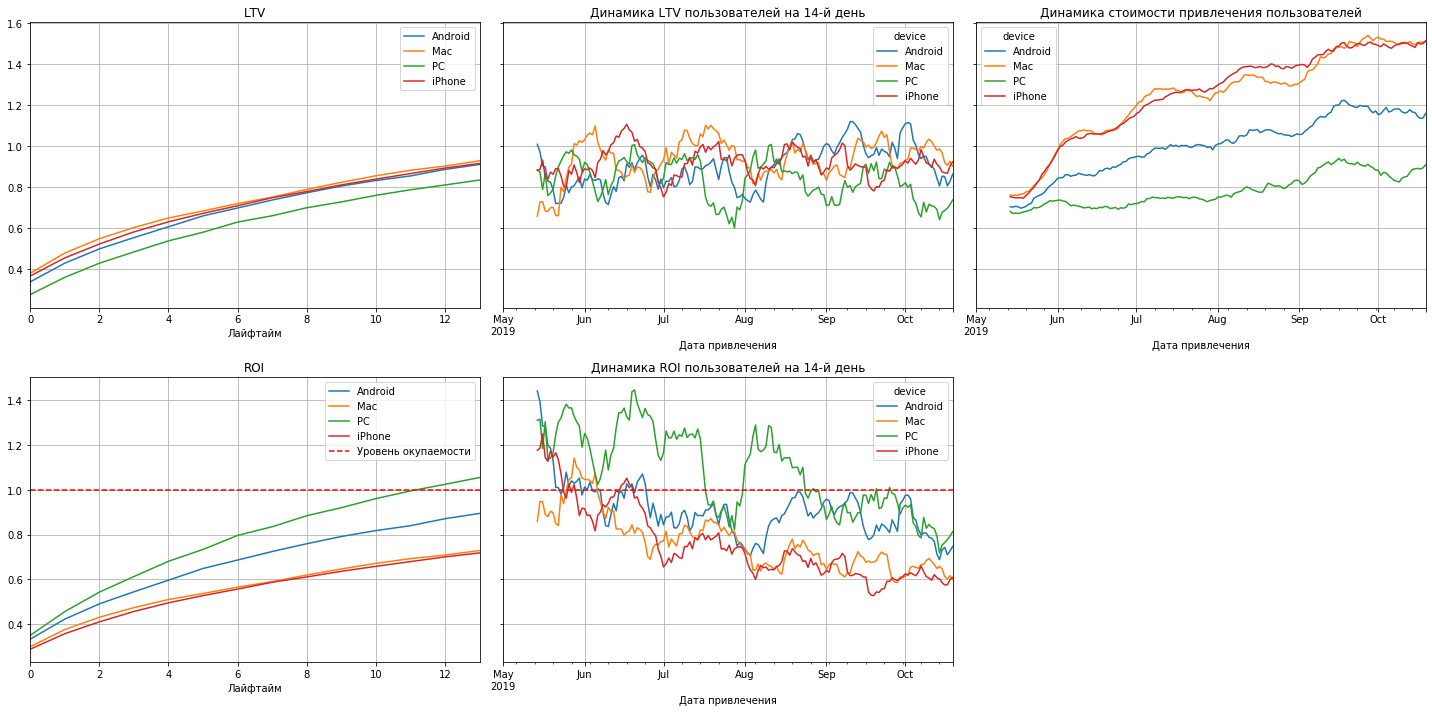

In [58]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    user_payer, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Стабильное качество пользователей и все устройства стабильно не окупаются кроме PC.
Узнаю, в чём причина: в низкой конверсии или низком удержании.

### Конверсия и удержание с разбивкой по устройствам

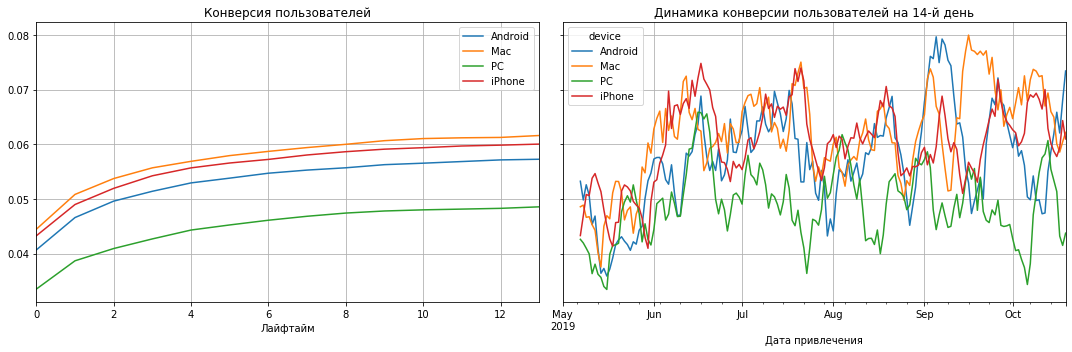

In [59]:
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    users, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Судя по графикам, пользователи всех устройств конвертируются очень хорошо, причём постоянно.

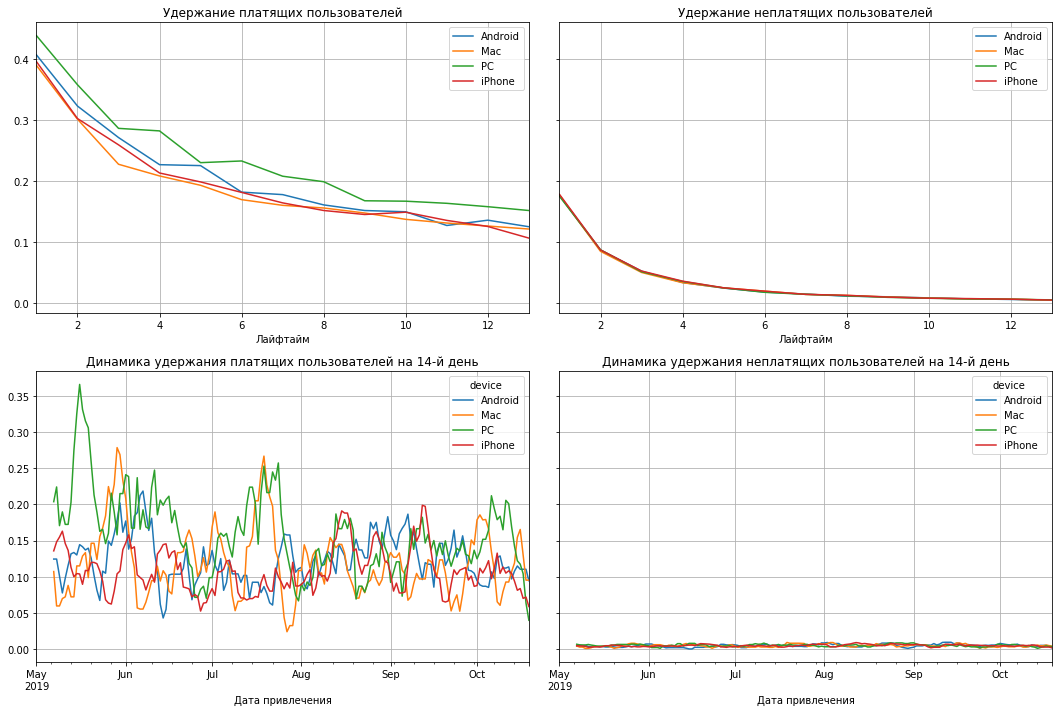

In [60]:
dimensions = ['device']
retention_raw, retention_grouped, retention_history = get_retention(
    users, sessions, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Пользователи всех устройств стабильно плоха удерживаются.

### Конверсия и удержание с разбивкой по странам:

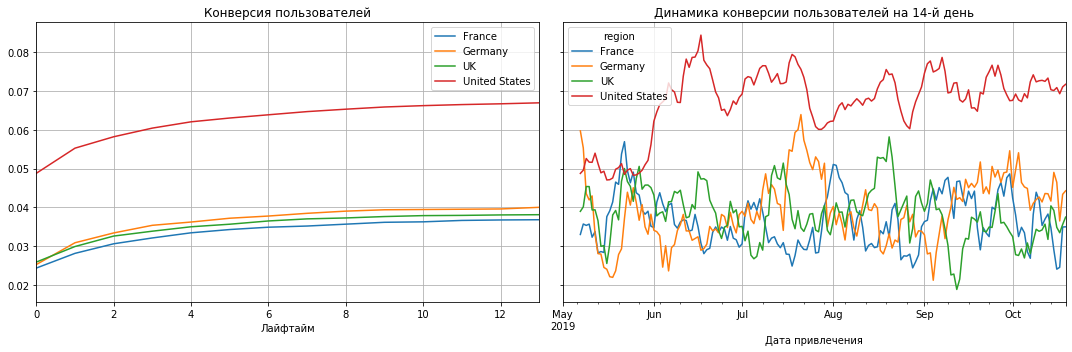

In [61]:
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    users, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Судя по графикам, пользователи конвертируются очень хорошо, причём постоянно. Лучший показатель у пользователей изUnited States. Видимо, дело в удержании.

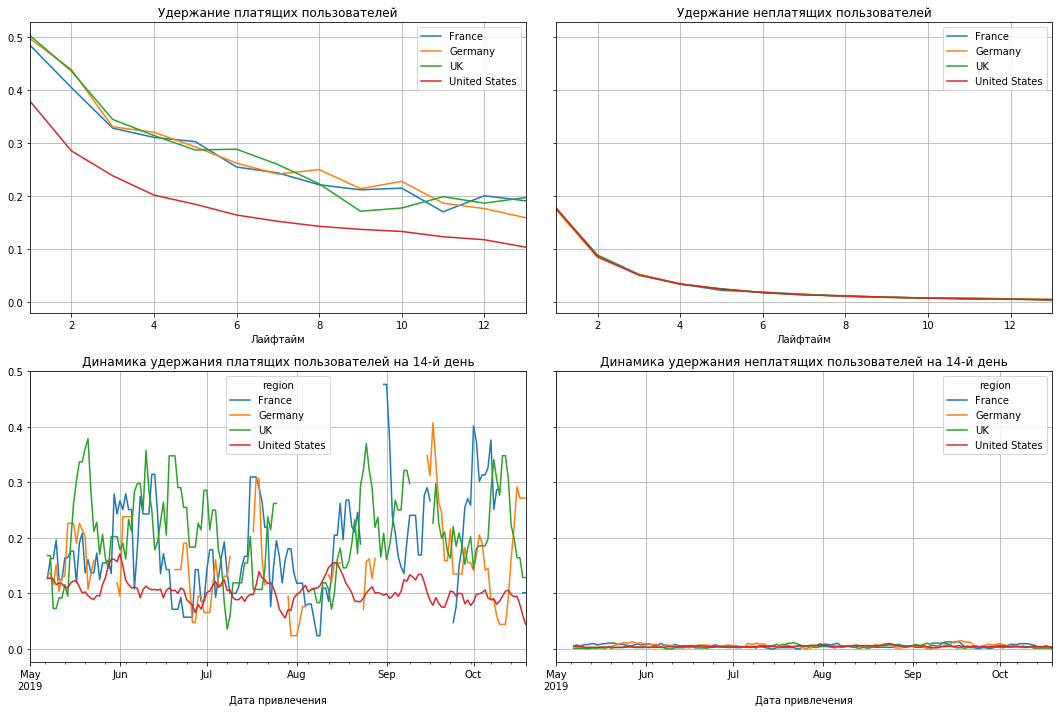

In [62]:
dimensions = ['region']
retention_raw, retention_grouped, retention_history = get_retention(
    users, sessions, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Пользователи из всех стран имеют низкий показатель удержания и хуже всех обстоят дела у пользователей из United States. 

### Конверсия и удержание с разбивкой по рекламным каналам:

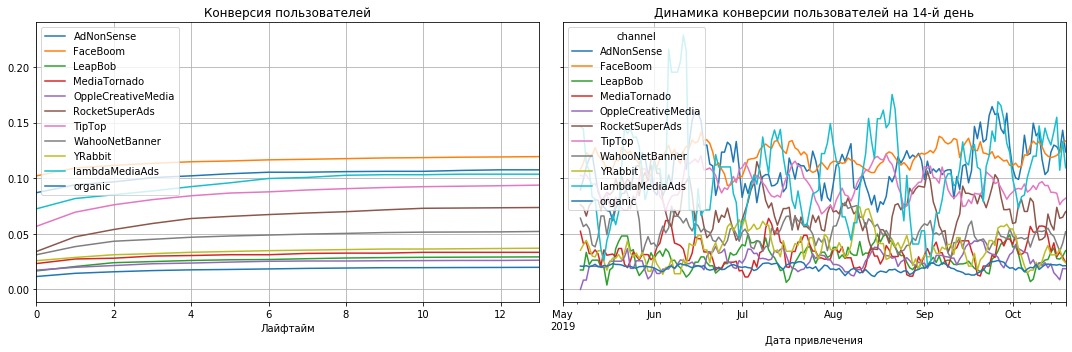

In [63]:
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    users, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

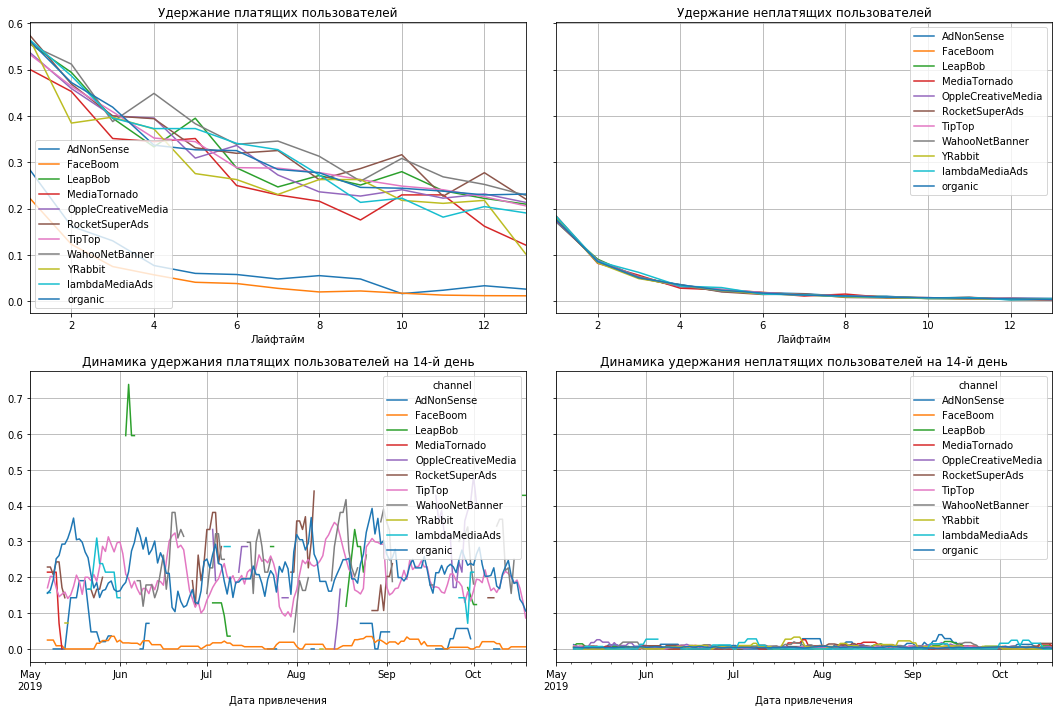

In [64]:
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    users, sessions, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Опять та же картина, хорошая конверсия и плохое удержание. 

### Ответы на вопросы:

__1. Окупается ли реклама в целом?__<br>
Реклама не окупается. Динамика ROI стабильно снижается. В конце второй недели — чуть выше 80%.<br>
CAC растёт.<br> 
LTV достаточно стабилен.

__2. Какие устройства, страны и каналы могут снижать окупаемость?__<br>
Все устройства стабильно не окупаются кроме PC. <br>
Судя по графикам самая многочисленная и единственная когорта из США тянет вниз все показатели окупаемости.<br>
ROI стабильно ниже нуля у TipTop, FaceBoom, AdNonSense.<br>

__3. Чем могут быть вызваны проблемы окупаемости?__<br>
Все проблемы маркетинга находятся в США, которые из-за своей многочисленности тянут вниз показатели в целом. В когорте США при лучшей конверсии, наихудший показатель удержания. И это при том, что CAC для США постоянно растёт и в основном за счёт одного источника TipTop. Который, в свою очередь, вкупе с FaceBoom и AdNonSense показывают наихудшие результаты окупемости и удержания.<br>

Для того, чтобы написать окончательные выводы проведу дополнительное исследование рынка США.


## United States. Дополнительное исследование. 

Создам таблицу пользовательских профилей:

In [65]:
user_us = users[(users['region'] == 'United States')]

Таблица пользовательских профилей без органических пользователей:

In [66]:
user_payer_us = user_us[~(user_us['channel'] == 'organic')]

Узнаю, какими устройствами пользуются клиенты, и какие устройства предпочитают платящие пользователи.

In [67]:
user_device_us = (user_us.groupby('device').agg({'user_id': 'nunique', 'payer': 'mean'})).sort_values(by = 'payer', ascending = False)
user_device_us['doly, %'] = (user_device_us['user_id'] / user_device_us['user_id'].sum() * 100).round(1)
print(user_device_us)

         user_id     payer  doly, %
device                             
Android    20194  0.073636     20.2
Mac        24837  0.068688     24.8
PC         10431  0.068546     10.4
iPhone     44514  0.067260     44.5


Количество посетителей, привлечённых каждым рекламным источником:

In [68]:
user_channel_us = (user_us.groupby('channel').agg({'user_id': 'nunique', 'payer': 'mean'})).sort_values(by = 'payer', ascending = False)
user_channel_us['doly, %'] = (user_channel_us['user_id'] / user_channel_us['user_id'].sum() * 100).round(1)
print(user_channel_us)

                user_id     payer  doly, %
channel                                   
FaceBoom          29135  0.122087     29.1
TipTop            19556  0.096032     19.6
RocketSuperAds     4447  0.079154      4.4
YRabbit            4312  0.038265      4.3
MediaTornado       4363  0.035755      4.4
organic           38163  0.020805     38.2


Расходы на маркетинг по источникам:

In [69]:
costs_channel_us = user_payer_us.groupby('channel').agg({'acquisition_cost': 'sum'}).sort_values(by = 'acquisition_cost', ascending = False)
costs_channel_us['doly, %'] = (costs_channel_us['acquisition_cost'] / costs_channel_us['acquisition_cost'].sum() * 100).round(1)
print(costs_channel_us)

                acquisition_cost  doly, %
channel                                  
TipTop                  54751.30     60.2
FaceBoom                32445.60     35.7
RocketSuperAds           1833.00      2.0
MediaTornado              954.48      1.0
YRabbit                   944.22      1.0


Средняя стоимость(CAC) привлечения одного пользователя из каждого источника:

In [70]:
cac_user_us_channel = (user_payer_us.groupby('channel').agg({'acquisition_cost': 'mean'})).sort_values(by = 'acquisition_cost', ascending = False)
print(cac_user_us_channel)

                acquisition_cost
channel                         
TipTop                  2.799719
FaceBoom                1.113630
RocketSuperAds          0.412188
YRabbit                 0.218975
MediaTornado            0.218767


Общая окупаемость рекламы

In [71]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    user_payer_us, orders, observation_date, horizon_days)

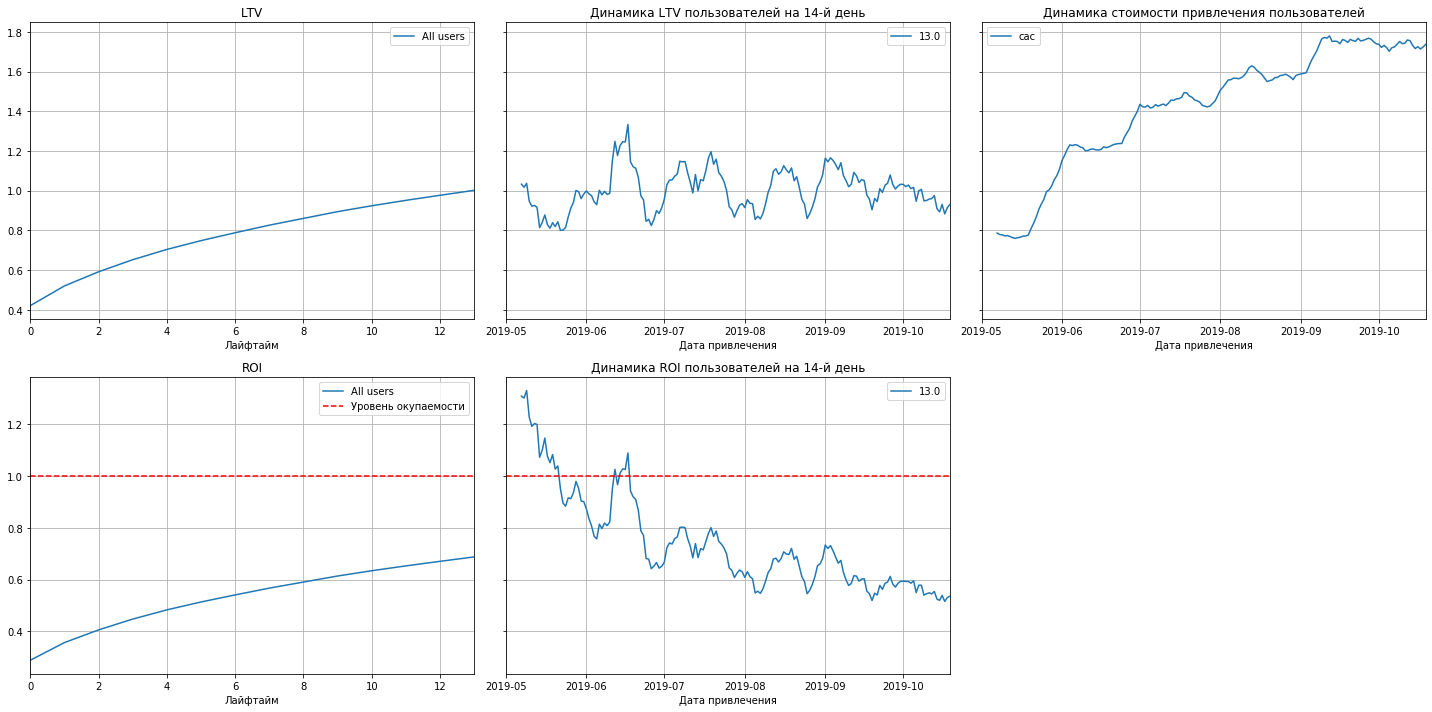

In [72]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Окупаемость рекламы с разбивкой по рекламным каналам:

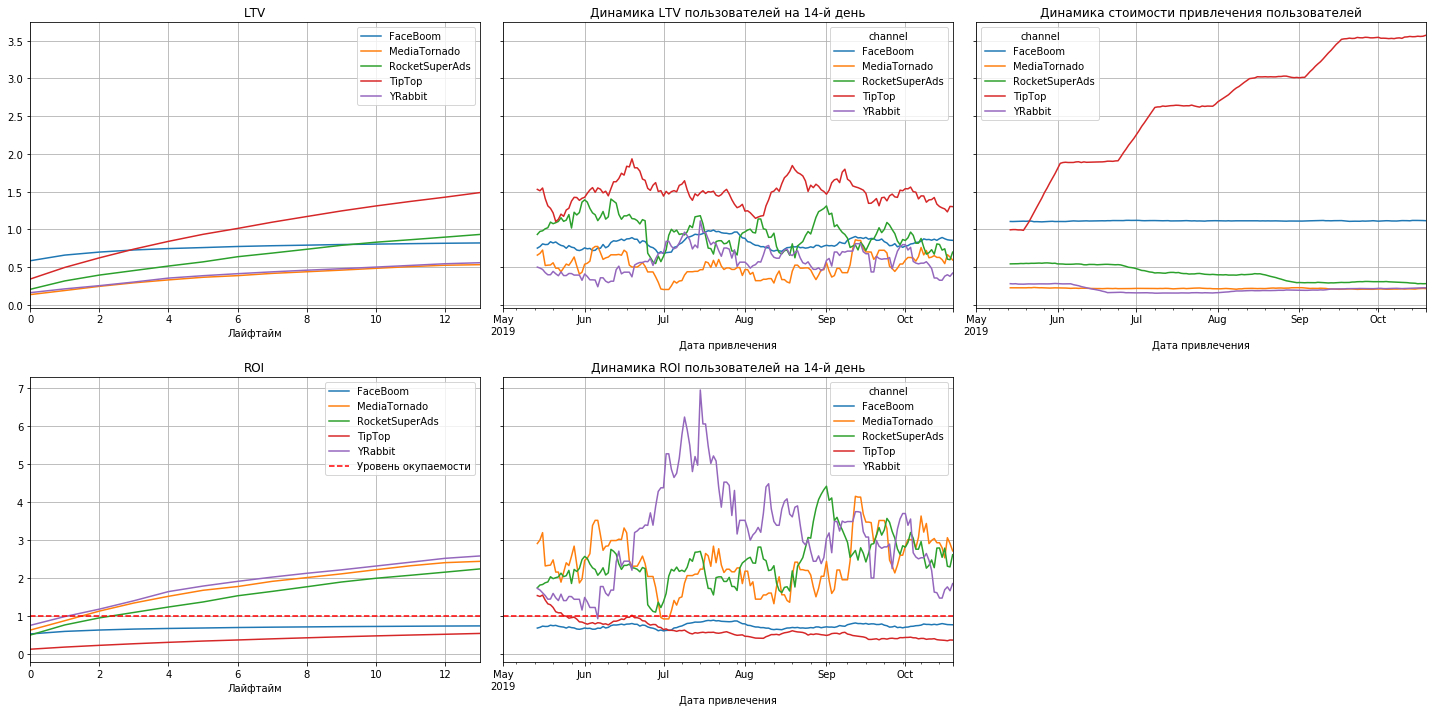

In [73]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    user_payer_us, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Окупаемость рекламы с разбивкой по устройствам:

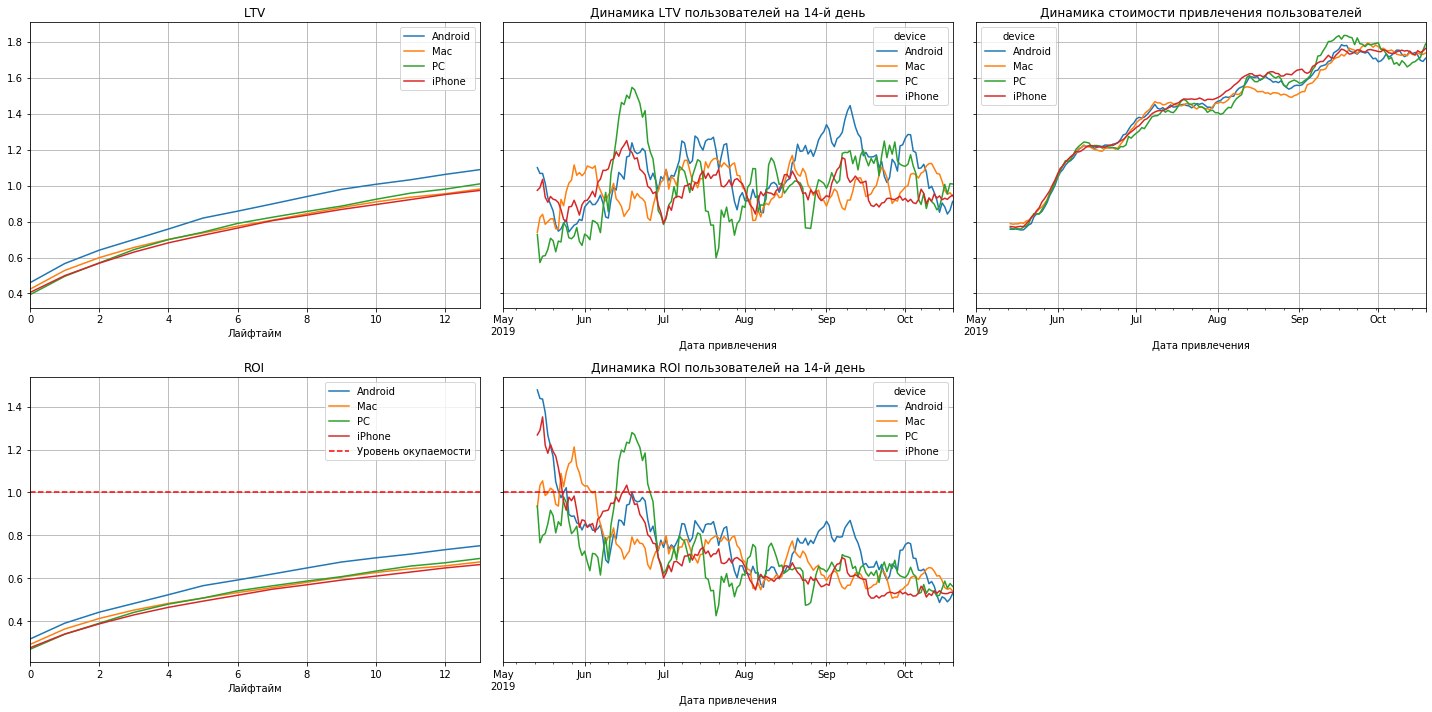

In [74]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    user_payer_us, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Конверсия с разбивкой по устройствам:

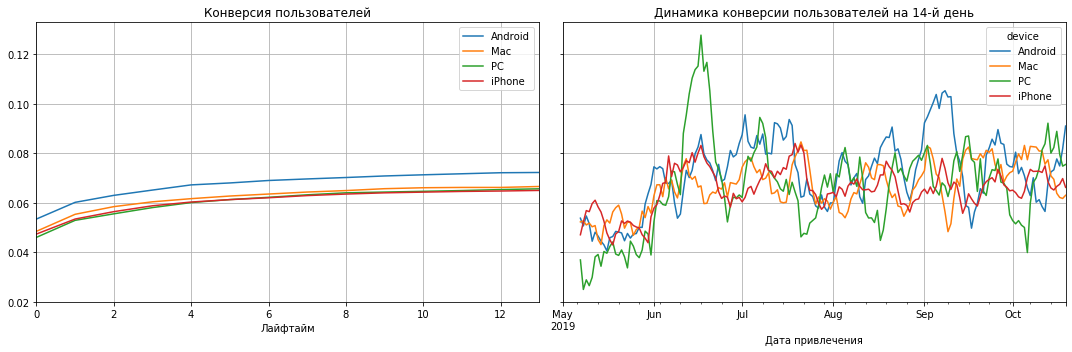

In [75]:
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    user_us, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Удержание с разбивкой по устройствам:

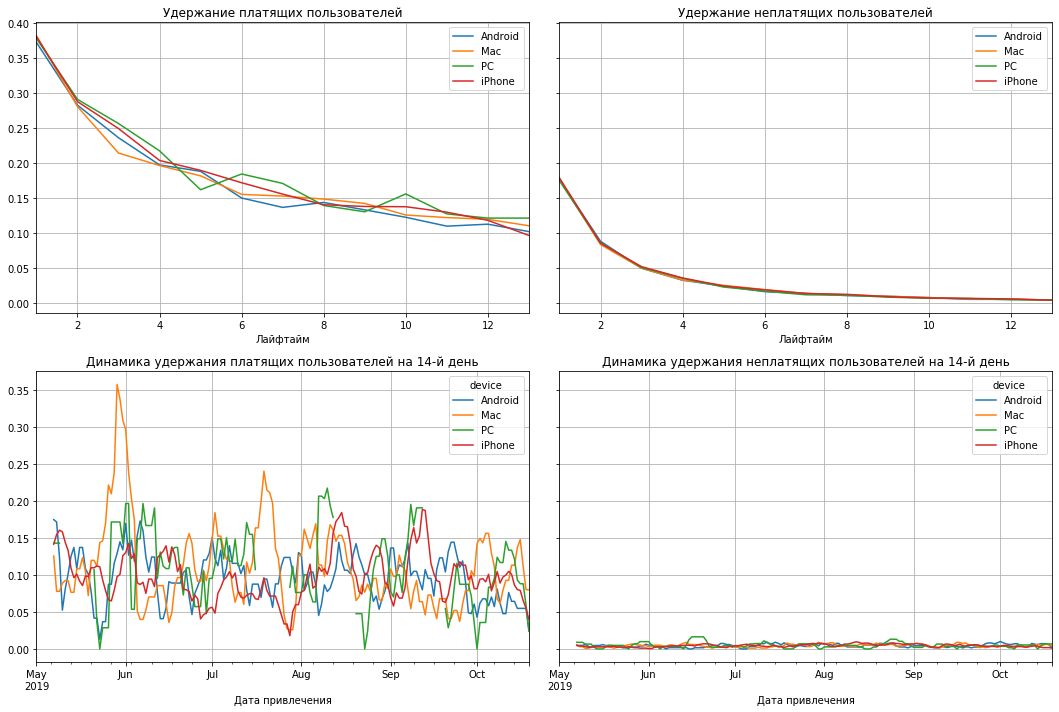

In [76]:
dimensions = ['device']
retention_raw, retention_grouped, retention_history = get_retention(
    user_us, sessions, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Конверсия с разбивкой по рекламным каналам:

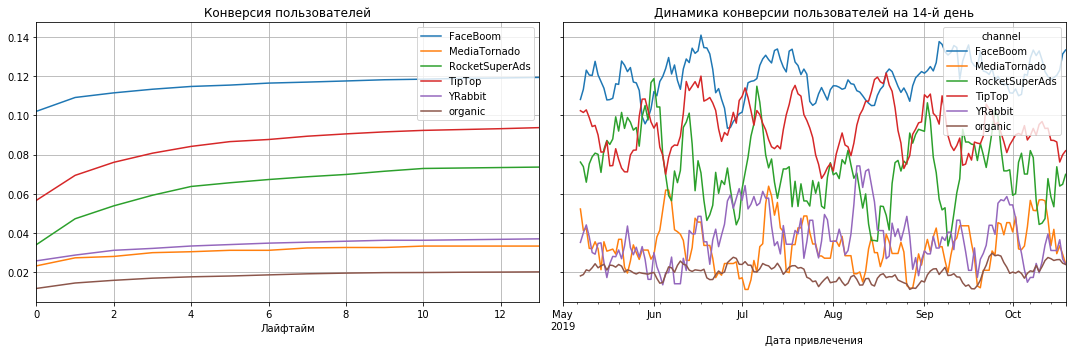

In [77]:
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    user_us, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Удержание с разбивкой по рекламным каналам:

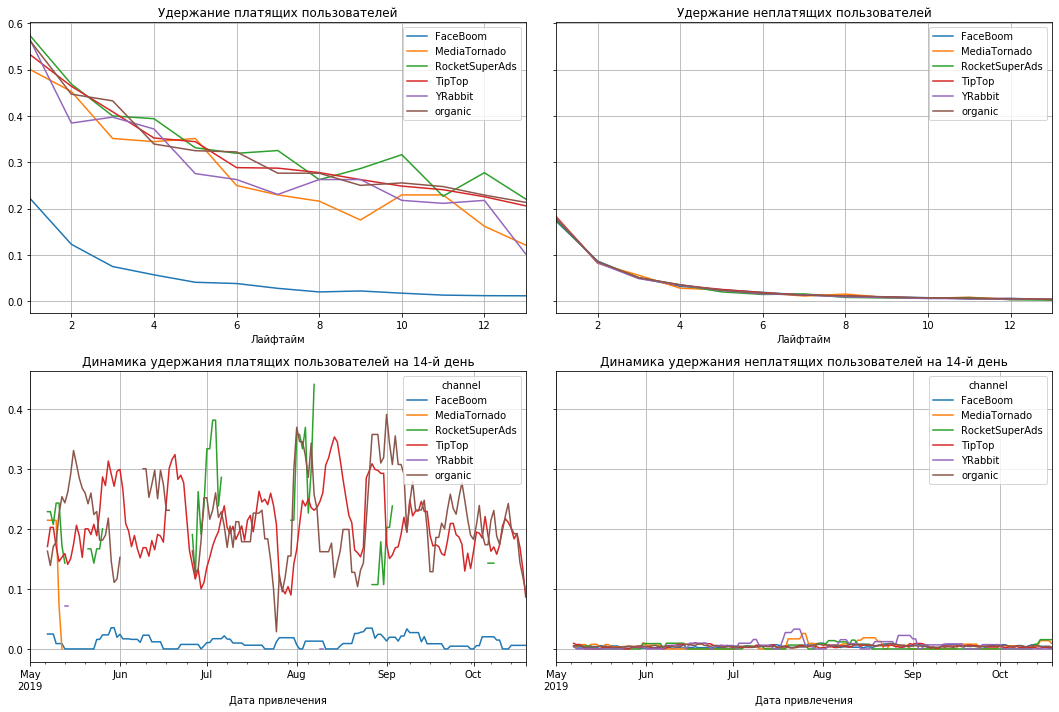

In [78]:
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    user_us, sessions, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Дополнительная информация по рынку США получена, можно переходить к выводам.

## Выводы

__1. Исходные данные:__ <br>

Данные чистые. Потребовались незначительные манипуляции: приведение названий столбцов к нижнему регистру, изменение типов данных дат, удаление нулевых сессий.<br>

__2. Теоретическое обоснование:__ <br>

Для целей исследования использован следующий теоретический и практический инструментарий:<br>
- Когортный анализ: удобный инструмент исследования клиентов компании. <br>
- Юнит-экономика: новые подходы и метрики в сочетании с когортным анализом позволяют эффективнее расследовать причины бизнес-неудач.<br>
- Пользовательские метрики: позволяют оценивать активность пользователей по количеству и продолжительности сессий.<br>
- Функции для расчета, анализа и визуализации CAC, LTV, ROI, удержания и конверсии: ускорили и упростили работу над проектом.<br>

__3. Выявленные проблемы:__<br>

- События events отсутствуют.<br>
- 82.7% всех расходов на рекламу приходится на два источника рекламы: TipTop - 51.9% и FaceBoom - 30.8%. При этом у TipTop самая высокая стоимость привлечений одного пользователя - 2.8.<br>
- В целом по проекту реклама не окупается. Динамика ROI стабильно снижается. В конце второй недели — чуть выше 80%.  CAC растёт.<br>
- Стоимость привлечения пользователей CAC стабильно для всех источников рекламы, кроме TipTop.  ROI стабильно ниже нуля у TipTop, FaceBoom, AdNonSense.<br>
- Самая многочисленная когорта из США, единственные у кого показатели окупаемости стабильно ниже нуля по всему периоду исследования.<br>
- все устройства стабильно не окупаются кроме PC.<br>
- По всем когортам хорошая конвертация и стабильно низкий показатель удержания.<br>

__4. Причины проблем:__<br>

Оценка окупаемости рекламы выявила, что все проблемы маркетинга находятся в США.<br>
Дополнительный анализ подтвердил этот вывод:<br>
В когорте США при лучшей конверсии среди всех представленных регионов, наихудший показатель удержания. И это при том, что CAC для США постоянно растёт и в основном за счёт одного источника TipTop. Который, в свою очередь, вкупе с FaceBoom и AdNonSense показывают наихудшие результаты окупаемости и удержания по всему периоду исследования.<br>
Отсюда вытекают две причины неэффективности привлечения пользователей:
- Расходы на маркетинг по каналу TipTop для США не дают положительного эффекта. При CAC=1.11 FaceBoom привлекает 60.2% пользователей, тогда как, при CAC=2.8 TipTop привлекает 35.7% пользователей. И это при том, что оба канала и без этого находятся вне зоны окупаемости по всему периоду исследования. <br>
- низкий показатель удержания в когорте США предполагает или отсутствие, или неэффективную работу с потребителями после конверсии.<br>

__5. Рекомендации отделу маркетинга:__

1. Низкий показатель удержания может быть связан как, и с работой развлекательного приложения Procrastinate Pro+., так и с завышенными ожиданиями пользователей, возникающими в связи с агрессивной рекламой. Вполне вероятно, необходимо разработать дополнительные мероприятия с целью удержания потребителей. Потому отделу маркетинга следует дополнительно изучить этот момент.<br>
2. Стоит пересмотреть политику расходов на рекламу в отношении канала TipTop в частности и на рынке США в общем.<br>
3. Есть смысл разработать рекламную кампанию по повышению конверсии в Germany, UK и France. <br>
4. Не зацикливаться на двух популярных каналах и обратить внимание на каналы со стабильно высоким ROI, они могут увеличить количество платящих пользователей. 


